**1. Read and import data**

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [100]:
dataset = pd.read_csv('./data/salary.csv', sep='|')

In [101]:
dataset.head(2)

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary
0,1,Facility Maintenance & Smart Warehouse Manager,Bandung,IDR,Manajer/Asisten Manajer,5 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pemeliharaan",NaN,NaN,NaN,NaN,Deskripsi PekerjaanRequirements :D3/SI from re...,NaN
1,2,Procurement Department Head,Jakarta Raya,IDR,Manajer/Asisten Manajer,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",NaN,25 days,51 - 200 pekerja,Manajemen/Konsulting HR,Job Role: 1. Responsible for material availabi...,NaN


**2. Cleaning the data**

In [102]:
# Remove Column & Null Value 
dataset = dataset.drop(labels=["id", "salary_currency", "job_benefits", "job_function", "job_description",
"company_process_time", "company_size", "company_industry"], axis=1)
dataset.dropna(inplace=True)

In [103]:
dataset.head(2)

,job_title,location,career_level,experience_level,education_level,employment_type,salary
9,Tax Supervisor,Banten,Supervisor/Koordinator,3 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,8000000.0
18,Accounting Staff,Jakarta Pusat,Pegawai (non-manajemen & non-supervisor),1 tahun,"SMA, SMU/SMK/STM, Sertifikat Professional, D3 ...",Penuh Waktu,4750000.0


In [104]:
# Nampilin tipe kolom "Object" & "Number"
objectType  = dataset.select_dtypes(['object']).columns
numericType  = dataset.select_dtypes(['number']).columns
print(objectType)
print(numericType)

Index(['job_title', 'location', 'career_level', 'experience_level',
       'education_level', 'employment_type'],
      dtype='object')
Index(['salary'], dtype='object')


In [105]:
# Check null values
dataset.isnull().sum()

job_title           0
location            0
career_level        0
experience_level    0
education_level     0
employment_type     0
salary              0
dtype: int64

In [106]:
dataset[numericType].describe()

,salary
count,8.570000e+03
mean,7.637237e+06
std,2.241025e+07
min,1.000000e+01
25%,4.371250e+06
50%,5.700000e+06
75%,8.400000e+06
max,2.000000e+09


**3. Discovering the data**

Top 10 Region Have The Highest Average Salary

In [107]:
topRegion = dataset[["location","salary"]]
topRegion = topRegion[(topRegion.groupby(['location'])['location'].transform('count') > 10)]
topRegion.set_index("location", inplace=True)

In [108]:
topRegion.groupby(['location'])['salary'].mean().astype(int).nlargest(10)

location
Sumatera Utara        11177024
Kalimantan Tengah     10619230
Tangerang             10316543
Jakarta Raya           9666784
Sulawesi Tengah        9529166
Aceh                   9482228
Kalimantan Timur       9442307
Jakarta Selatan        9286904
Bali                   9199430
Kalimantan Selatan     8325000
Name: salary, dtype: int32

Kind of Career Level

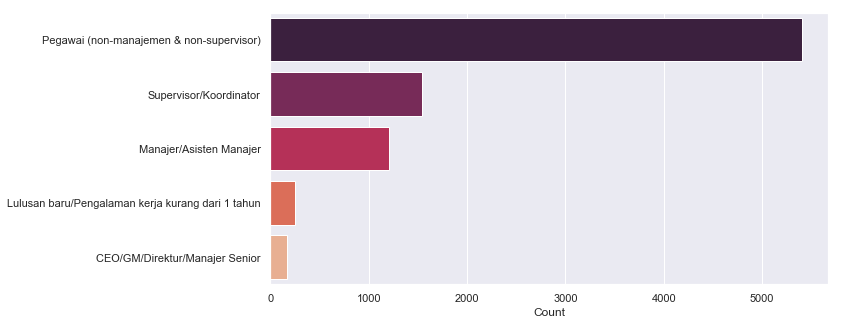

In [109]:
countCL = sns.load_dataset("tips")
sns.set(rc={'figure.figsize':(10, 5)})
sns.countplot(data = countCL, y = dataset["career_level"], palette="rocket", order = dataset["career_level"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("")
plt.show()

Average Salary by size of Career Level

In [110]:
dataset.groupby(by="career_level")["salary"].mean().round(0).astype("int").nlargest()

career_level
CEO/GM/Direktur/Manajer Senior                       25860062
Manajer/Asisten Manajer                              13017445
Supervisor/Koordinator                                7754286
Pegawai (non-manajemen & non-supervisor)              5960257
Lulusan baru/Pengalaman kerja kurang dari 1 tahun     4812583
Name: salary, dtype: int32

Kind of Experience Level

In [111]:
dataset["experience_level"] = dataset["experience_level"].str.replace("\D", "").fillna(0).astype('int')

In [123]:
type_com = []
for i in dataset['experience_level']:
    if i == 0:
        type_com.append('No Experience')
    elif 1 <= i <= 4:
        type_com.append('1-4 Years')
    elif 5 <= i <= 9:
        type_com.append('5-9 Years')
    elif 10 <= i <= 14:
        type_com.append('10-14 Years') 
    elif 15 <= i <= 19:
        type_com.append('15-19 Years')            
    else:
        type_com.append('20+ Years')
dataset['type_of_experience'] = type_com

In [127]:
dataset.groupby(by="type_of_experience")["salary"].mean().round(0).astype("int").nlargest()

type_of_experience
20+ Years      36583333
15-19 Years    31680000
10-14 Years    27304702
5-9 Years      12678566
1-4 Years       6625376
Name: salary, dtype: int32

In [125]:
dataset[["experience_level", "type_of_experience"]]

,experience_level,type_of_experience
9,3,1-4 Years
18,1,1-4 Years
22,2,1-4 Years
26,2,1-4 Years
28,1,1-4 Years
31,5,5-9 Years
34,2,1-4 Years
35,1,1-4 Years
37,1,1-4 Years
38,1,1-4 Years


Average Salary by size of Experience Level

**4. Predict the salary**